# Trading Game

In [135]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from functions import *
from itertools import count
buyer_strategies = ['Honest']
seller_strategies = ['Random','Random','Random','Random','Random','Random','Random','Random']
nbuyers, nsellers = len(buyer_strategies), len(seller_strategies)
nrounds, nperiods, ntokens, nsteps, gametype, nbuyers, nsellers = 1, 100, 3, 6, '1234', len(buyer_strategies), len(seller_strategies)
R1, R2, R3, R4 = gametype_to_ran(gametype)
game_metadata = [nrounds, nperiods, ntokens, nbuyers, nsellers, nsteps, R1, R2, R3, R4]
db = Database(game_metadata, buyer_strategies, seller_strategies)
rnd = 0
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
period = 0
num_actions = 6
num_states = nsteps
min_frac = 0.1
max_frac = 1.0
action_to_bid_frac = np.linspace(0,1,num_actions)

In [136]:
class TradingEnv(gym.Env):
    def __init__(self, db, nsteps, render_mode = None):
        self.db = db
        self.action_space = spaces.Discrete(num_actions)
        self.observation_space = spaces.Discrete(num_states)

    def reset(self, rnd):
        self.db.reset_period(rnd)
        observation = np.array([0])
        return observation, None

    def step(self, action, timestep, period, rnd, seed = None, options = None):
        bid_frac = action_to_bid_frac[action]
        # convert action to bid
        self.db.buyers[0].next_token()
        min_bid = self.db.buyers[0].value*min_frac
        max_bid = self.db.buyers[0].value*max_frac
        bid = np.round(max_bid * bid_frac + (1-bid_frac)*min_bid,1)
        
        # simulate market
        bids = [buyer.ask(self.db) for buyer in self.db.buyers]
        bids[0] = bid
        asks = [seller.ask(self.db) for seller in self.db.sellers]
        current_ask, current_ask_idx, current_bid, current_bid_idx = current_bid_ask(bids, asks) 
        sale, price, bprofit, sprofit, buy, sell = buy_sell(db, current_bid, current_bid_idx, current_ask, current_ask_idx)
        step_data = [rnd,period,timestep,bids,asks,current_bid,current_bid_idx,current_ask,current_ask_idx,buy,sell,price,sale,bprofit,sprofit]
        self.db.add_step(step_data)
        
        # compute reward, new state
        reward = np.array([0])
        if (sale == 1) and (current_bid_idx == 0):
            reward = np.array([bprofit])
        observation = np.array([timestep + 1])
        
        # check termination 
        if timestep == nsteps-1:
            terminated = True
        else:
            terminated = False
        return observation, reward, terminated, False, None

In [ ]:
env = TradingEnv(db, nsteps)
rnd = 0
observation, info = env.reset(rnd)
for period in count():
    for timestep in count(): 
        action = env.action_space.sample()
        observation, reward, done, info, reset_info = env.step(action, timestep, period, rnd)
        print(f"Rnd: {rnd}, Period: {period}, New State: {observation}, Action:{np.round(action,1)}, Reward: {np.round(reward,1)}, Period End: {done}")

        if done:
            # If the episode is done, reset the environment
            print('done')
            observation, info = env.reset(rnd)
            timestep += 1
            break
    if period == nperiods:
        break

# Close the environment when done
env.close()

# DQN

In [137]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [138]:
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [139]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 256)
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [140]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1)[1].view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [141]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0]
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [142]:
db = Database(game_metadata, buyer_strategies, seller_strategies)
rnd = 0
db.reset_round(rnd, ntokens, nbuyers, nsellers, R1, R2, R3, R4)
period = 0
num_states = nsteps
min_frac = 0.1
max_frac = 1.0
action_to_bid_frac = np.linspace(0,1,num_actions)
rnd = 0
env = TradingEnv(db, nsteps)
BATCH_SIZE = 256
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 500
TAU = 0.005
LR = 1e-2
n_actions = env.action_space.n
state, info = env.reset(rnd)
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(30000)
steps_done = 0
episode_durations = []

0 68.45 [3, 3, 5, 0, 3, 3] 0.8898609559326409
1 82.20000000000002 [1, 3, 4, 3, 3, 5] 0.879842853294223
2 89.0 [1, 1, 3, 3, 1, 5] 0.8699442494606546
3 89.3875 [1, 4, 3, 3, 3, 4] 0.8601637190158791
4 84.18 [5, 4, 3, 1, 2, 3] 0.8504998535466114
5 85.63333333333334 [1, 3, 2, 1, 4, 4] 0.8409512614395249
6 87.10000000000001 [0, 0, 2, 1, 0, 5] 0.831516567680856
7 89.86250000000001 [0, 3, 3, 3, 3, 2] 0.8221944136584003
8 87.37222222222223 [5, 0, 4, 5, 1, 4] 0.8129834569658697
9 86.19500000000002 [4, 3, 1, 3, 5, 0] 0.8038823712095838
10 87.9818181818182 [1, 2, 3, 1, 1, 3] 0.7948898458174672
11 88.64583333333336 [2, 2, 0, 5, 5, 3] 0.7860045858503243
12 88.15384615384617 [2, 3, 3, 3, 3, 3] 0.7772253118153657
13 87.13214285714287 [4, 3, 0, 5, 4, 2] 0.7685507594819599
14 86.02000000000001 [4, 0, 5, 5, 0, 5] 0.7599796796995812
15 85.51250000000002 [3, 1, 5, 3, 1, 3] 0.75151083821793
16 85.54117647058825 [3, 2, 3, 3, 1, 4] 0.7431430155091988
17 85.2277777777778 [3, 3, 1, 4, 3, 3] 0.7348750065924577
1

151 90.7175 [1, 3, 3, 3, 3, 3] 0.18717210104816417
152 91.5425 [3, 4, 1, 1, 1, 1] 0.18553587283952938
153 91.275 [1, 1, 1, 1, 1, 1] 0.18391916203079062
154 90.99250000000002 [1, 1, 1, 2, 3, 3] 0.1823217358127977
155 90.87 [3, 3, 3, 3, 3, 3] 0.18074336415341485
156 90.64250000000001 [3, 3, 3, 3, 3, 3] 0.1791838197643958
157 88.97000000000001 [3, 3, 3, 3, 1, 1] 0.17764287806865348
158 88.91750000000002 [1, 2, 2, 2, 0, 0] 0.17612031716792098
159 89.22750000000002 [0, 0, 0, 2, 0, 0] 0.17461591781079763
160 90.24000000000002 [0, 0, 0, 0, 0, 1] 0.17312946336117638
161 91.17 [1, 1, 1, 1, 0, 2] 0.17166073976704785
162 91.20750000000001 [2, 2, 2, 2, 2, 2] 0.17020953552967655
163 90.765 [2, 2, 2, 2, 2, 2] 0.1687756416731446
164 89.67 [2, 5, 2, 2, 2, 2] 0.1673588517142589
165 89.0 [2, 1, 1, 1, 1, 1] 0.1659589616328171
166 88.9375 [1, 4, 1, 4, 4, 0] 0.16457576984222846
167 90.27000000000001 [4, 2, 2, 5, 2, 2] 0.163209077160485
168 90.16 [2, 2, 2, 5, 2, 2] 0.1618586867814789
169 89.77750000000002 [

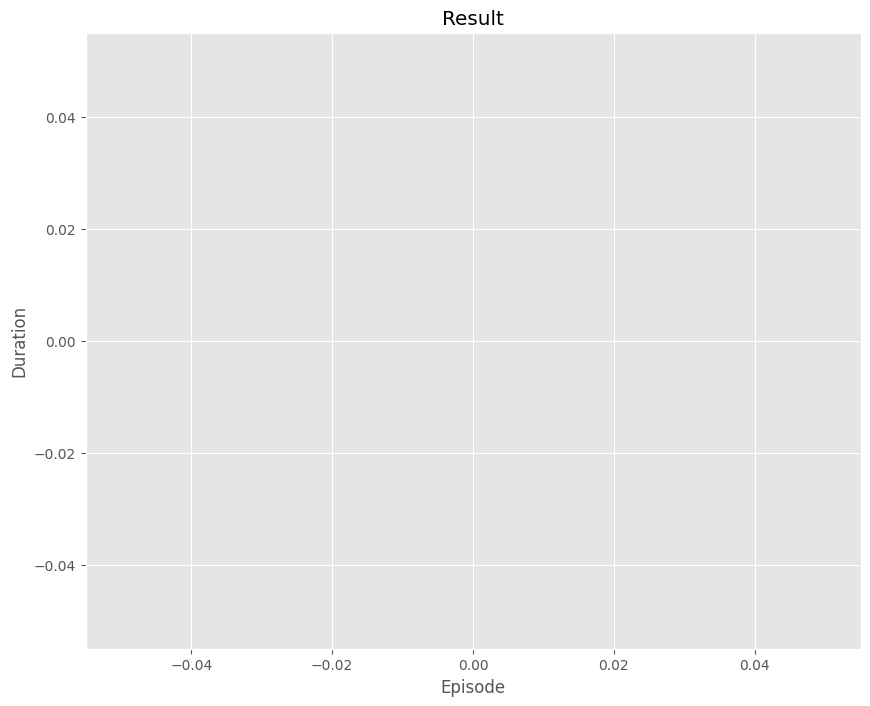

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

In [143]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 200
    
rnd = 0
period_reward_history = []
for period in range(num_episodes):
    state, info = env.reset(rnd)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    period_reward = np.array([0.0])
    actions_taken = []
    for timestep in count():
        action = select_action(state)
        actions_taken.append(action.item())
        observation, reward, terminated, truncated, _ = env.step(action.item(), timestep, period, rnd)
        period_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        memory.push(state, action, next_state, reward)
        state = next_state
        optimize_model()
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
        if done:
            eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
            #episode_durations.append(t + 1)
            #plot_durations()
            break
    period_reward_history.append(period_reward.item())
    print(period, np.mean(period_reward_history[-20:]), actions_taken, eps)
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
env.db.step_data = env.db.step_data.drop_duplicates(subset=['rnd','period','step'], keep='last')

In [ ]:
env.db.step_data.tail(20)

# Graph

In [ ]:
def graph(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm, 
                        period_bids, period_asks, period_prices, period_sales, 
                        redemption_values, token_costs, ntokens, nbuyers, nsellers, nsteps):
    plt.plot(demand_schedule, P_grid, label = 'Demand Curve')
    plt.plot(supply_schedule, P_grid, label = 'Supply Curve')
    plt.plot(period_prices, color='green', linestyle='--', label='Mean Real Prices')
    plt.axhline(y=np.nanmean(p_eqbm), color='black', linestyle='--', label='Mean Eqbm Prices')
    prices = []
    for i in range(nsteps):
        if (period_prices[i] > 0):
            plt.scatter([period_sales[i]]*len(period_bids[i]), period_bids[i], s = 10, marker = 'x', c = 'red')
            plt.scatter([period_sales[i]]*len(period_asks[i]), period_asks[i], s = 10, marker = 'o', c = 'blue')
        else:
            pass  
    plt.legend()
    text_content = f'q*={q_eqbm}, mean(q)={np.round(np.nanmax(period_sales),1)},p*={np.round(p_eqbm,1)}, mean(p)={np.round(np.nanmean(period_prices),1)}'
    plt.title(text_content)
    #plt.xlim(0,5*1.2)
    #plt.ylim(0,5*3.0)
    plt.show()
    
    plt.plot(period_bids, c = 'r', linestyle='--')
    plt.plot(period_asks, c = 'b', linestyle='--')
    plt.scatter(range(nsteps), period_prices, c = 'g')
    plt.title('Bids (red), Asks (blue) and Prices (green) over trading steps')
    plt.show()

def graph_period(db, rnd, period):
    period_bids = list(db.get_period(rnd, period).bids)
    period_asks = list(db.get_perioxd(rnd, period).asks)
    period_prices = list(db.get_period(rnd, period).price)
    period_sales = np.cumsum(np.where(db.get_period(rnd, period).price > 0,1,0))
    [_, demand_schedule, supply_schedule, P_grid, redemption_values, token_costs, p_eqbm, q_eqbm] = db.get_round(rnd).iloc[0].tolist()
    graph(demand_schedule, supply_schedule, P_grid, p_eqbm, q_eqbm, period_bids, period_asks, period_prices, period_sales, redemption_values, token_costs, db.ntokens, db.nbuyers, db.nsellers, db.nsteps)

In [ ]:
graph_period(env.db, 0, 1)

In [ ]:
graph_period(env.db,0,199)

In [ ]:
graph_period(env.db, 0, 199)